# Online Prediction Simulation

In [1]:
import numpy as np
import torch
from pickle import load

# custom modules
from method import compute_eval_matrices
from visualization import make_perform_video
from watercan import GroupWaterCan

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Get the testing data

In [3]:
dataset_name='uav_data'#'N-CMAPSS' #
threshold=''#'-0.1' #  '+0.1' #

# Load testing data

In [4]:
with open(f'./data/{dataset_name}/performs_info.pkl', 'rb') as file:
    performs_info=load(file)

with open(f'./data/{dataset_name}/times_test{threshold}.pkl', 'rb') as file:
    times = load(file)

with open(f'./data/{dataset_name}/times_test{threshold}_threshold.pkl', 'rb') as file:
    times_thresholds = load(file)

performs = {}
thresholds = {}
for name in performs_info.keys():
    with open(f'./data/{dataset_name}/{name}_test{threshold}.pkl', 'rb') as file:
        performs[name] = load(file)
    with open(f'./data/{dataset_name}/{name}_test{threshold}_threshold.pkl', 'rb') as file:
        thresholds[name]= load(file)

list(performs_info.keys())


['SOC', 'POS', 'CUM']

## Choose Library

In [5]:
library_exp=f'MTL_2024-08-17_{dataset_name}' 

## Load Group Distribution

In [6]:
exp_address=f'./Library/{library_exp}/'

group_distributions={}
for perform_name in performs_info.keys():
    perform_info=performs_info[perform_name]

    perform_address=exp_address+f'{perform_name}/'

    configs=torch.load(perform_address+'config.pth')
    model_state=torch.load(perform_address+'model_state.pth')
    model=GroupWaterCan(configs)
    model.load_state_dict(model_state)
    model.to(device)
    group_distributions[perform_name]=model
times_torch=[torch.tensor(time,device=device,dtype=torch.float32).unsqueeze(dim=1) for time in times]

# Compute and prepare A,b matrices and time

In [7]:
n_test_sys=len(times)
A,S=compute_eval_matrices(group_distributions,times_torch)
test_sys_list=range(n_test_sys)
b = performs
time_sys = times 

## Predicts and plot Performance Curves

In [8]:
import importlib
# importlib.reload(method)
import method
from method import compute_eval_matrices

In [12]:
n_train_sys =20 # 6
n_paths = 20  # 10 #
#gamma={'HI': 100}
gamma={'SOC': 100,
        'POS': 100,
        'CUM': 100}
ood_coef=1.

In [17]:
system=1
#end_time=110
end_time=80
density_time=200
time_unit='hours' #'cycle'

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t: 100%|██████████| 69/69 [05:35<00:00,  5.36s/it, now=None]

stop


Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t: 100%|██████████| 69/69 [05:32<00:00,  5.09s/it, now=None]

stop


Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t: 100%|██████████| 69/69 [05:40<00:00,  5.24s/it, now=None]

stop


Moviepy - Done !
Moviepy - video ready __temp__.mp4


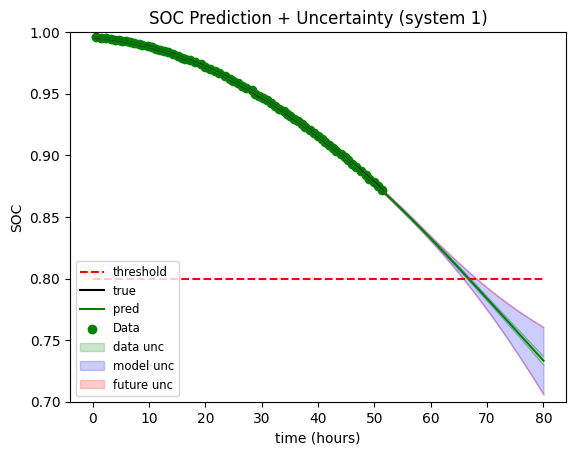

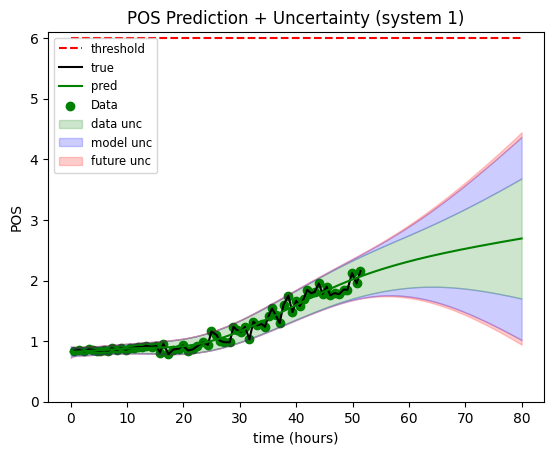

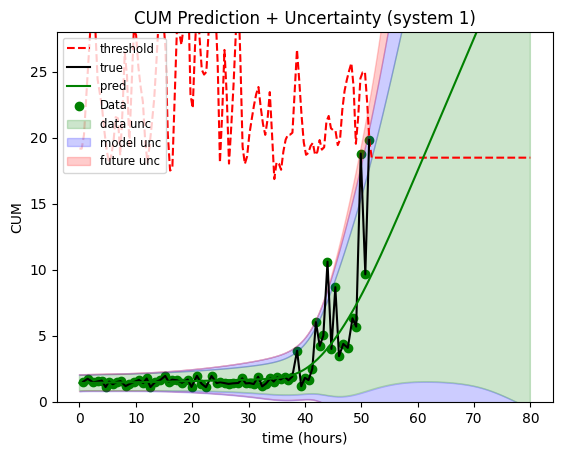

In [18]:
t = np.linspace(0, end_time, density_time)
for name in performs_info.keys(): #:['CUM']
        threshold=np.interp(t, times_thresholds[system], thresholds[name][system])
        threshold=torch.tensor(threshold,dtype=torch.float32)
        gamma_=gamma[name] 
        group_distribution=group_distributions[name].get_sub_watercan(range(n_train_sys))
        perform_info=performs_info[name].copy()
        perform_info['time_unit']=time_unit
        del perform_info['perform_name']
        del perform_info['monot']
        
        make_perform_video(system,group_distribution,threshold,
                        time_sys[system],A[name][system][:,:n_train_sys],b[name][system],S[name][system][:,:n_train_sys],A_est=None,b_est=None,
                        gamma=gamma_,n_train_sys=n_train_sys,n_paths=n_paths,ood_coef=ood_coef,
                        end_time=end_time,density_time=density_time,frames=20,
                        name=name,**perform_info)